In [15]:
from models.CNN import *
from datasets.dataset import *
from configs.train_config import TrainConfigs
import torch
from torch.utils.data import DataLoader
from pyhessian import hessian

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
!nvidia-smi

Sat Feb 10 05:31:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   28C    P8              18W / 320W |     25MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [18]:
device = 'cuda:0'
model = Small(num_class=10).to(device)
model.load_state_dict(torch.load('./naive.pt'))
model.eval()

Small(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3136, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): ReLU()
)

In [11]:
print('Size of linear1: ',model.linear1.weight.shape)
print('Rank of linear1:', torch.linalg.matrix_rank(model.linear1.weight))

print('Size of linear2: ',model.linear2.weight.shape)
print('Rank of linear2:', torch.linalg.matrix_rank(model.linear2.weight))

Size of linear1:  torch.Size([128, 3136])
Rank of linear1: tensor(128, device='cuda:0')
Size of linear2:  torch.Size([10, 128])
Rank of linear2: tensor(10, device='cuda:0')


In [13]:
train_data_path = [
    './datasets/data/cifar-10/cifar-10-batches-py/data_batch_1',
    './datasets/data/cifar-10/cifar-10-batches-py/data_batch_2',
    './datasets/data/cifar-10/cifar-10-batches-py/data_batch_3',
    './datasets/data/cifar-10/cifar-10-batches-py/data_batch_4',
    './datasets/data/cifar-10/cifar-10-batches-py/data_batch_5'
]

test_data_path = './datasets/data/cifar-10/cifar-10-batches-py/test_batch'

In [17]:
loss_fn = nn.CrossEntropyLoss()
train_dataset = CifarDataset(data_path=train_data_path[0])
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_dataset = CifarDataset(data_path=test_data_path)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)

In [26]:
for inputs, targets in train_dataloader:
    break
inputs = inputs.cuda()
targets = targets.cuda()
hessian_comp = hessian(model, loss_fn, data=(inputs, targets), cuda=True)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)
print("The top two eigenvalues of this model are: %.4f %.4f"% (top_eigenvalues[-1],top_eigenvalues[-2]))

The top two eigenvalues of this model are: 308.4731 1266.7828


In [22]:
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()

def get_params(model_orig,  model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d
    return model_perb

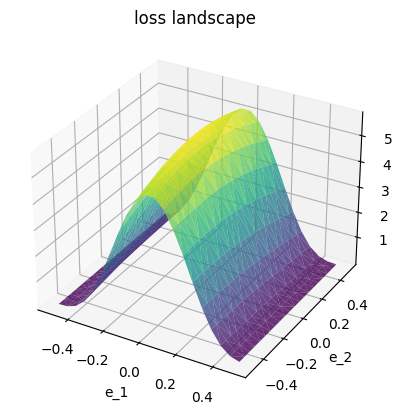

In [31]:
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)
lams1 = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []


model_perb = model
model_perb.eval()
model_perb = model_perb.cuda()

model_perb1 = model
model_perb1.eval()
model_perb1 = model_perb1.cuda()

for lam in lams:
    for lam1 in lams1:
        model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
        model_perb1 = get_params(model, model_perb1, top_eigenvector[1], lam1)
        loss_list.append((lam, lam1, loss_fn(model_perb(inputs), targets).item()))

loss_list = np.array(loss_list)

fig = plt.figure()
landscape = fig.add_subplot(projection='3d')
landscape.plot_trisurf(loss_list[:,0], loss_list[:,1], loss_list[:,2], alpha=0.8, cmap='viridis')

landscape.set_title('loss landscape')
landscape.set_xlabel('e_1')
landscape.set_ylabel('e_2')
landscape.set_zlabel('loss')

plt.show()

In [ ]:
wtf